### Description: Sparse Bayesian learning
#### Assumptions: scalar input, scalar output

###### Author: Rimple Sandhu, Carleton University; Email: rimple_sandhu@outlook.com

In [1]:
#!/usr/bin/python
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import os, math, sys

Assign polynomial basis (polyPower), hyper-parameters a,b,c,d and initial hyperparameter $\alpha$ and noise precision $\rho$:

In [2]:
poly0 = [0,1,2,3,4,5,6] # powers of polynomial basis
N = len(poly0) # number of coefficients 
Wlim = [-5,5]
Nsbl = 500

Generate design matrix $\Phi$, and load observations $Y$ and input $X$: 

In [3]:
def getPhiMat(X,polyPower):
    M = len(X)
    Phi = np.zeros((M,N))
    for i in range(0,M):
        for j in range(0,N): Phi[i,j] = X[i]**polyPower[j]
    return Phi
Yobs = np.loadtxt('Ydata.dat') 
Xobs = np.loadtxt('Xdata.dat')
PhiAll = getPhiMat(Xobs,poly0)
M = len(Yobs)

Sparse Bayesian leanring through Mackay's algorithm (similar to expectation maximizations):

In [4]:
def update_SBL(iGammaAll,iGammaProp,iSlopeLogEvid,iCheckQsqS,imall,iRho,iRhoFlag,printFlag):
    iN = np.count_nonzero(iGammaAll)
    iGamma = np.zeros((iN,1))
    iPhi  = np.zeros((M,iN))
    iParIndex = [int(0)]*iN
    ij=0
    for ii in range(0,N):
        if iGammaAll[ii,0] > 0.0: 
            iPhi[:,ij] = PhiAll[:,ii]
            iParIndex[ij] = ii
            iGamma[ij,0] = iGammaAll[ii,0]
            ij = ij +1
    iA    = np.diag(np.divide(1,iGamma[:,0]))
    iP    = np.linalg.inv(iA + iRho*np.matmul(np.transpose(iPhi),iPhi)) 
    im    = iRho*np.matmul(iP,np.matmul(np.transpose(iPhi),Yobs))
    ij=0
    for ii in range(0,N):
        if iGammaAll[ii,0] > 0: 
            imall[ii,0] = im[ij]
            ij = ij +1
        else:
            imall[ii,0] = 0.0
    itemp = np.matmul(iPhi,np.matmul(iP,np.transpose(iPhi)))
    for j in range(0,N):
        iSbar = iRho*np.sum(PhiAll[:,j]**2) - (iRho**2)*np.matmul(np.transpose(PhiAll[:,j]),np.matmul(itemp,PhiAll[:,j])) 
        iQbar = iRho*np.matmul(np.transpose(PhiAll[:,j]),Yobs) - (iRho**2)*np.matmul(np.transpose(PhiAll[:,j]),np.matmul(itemp,Yobs))
        iS    = iSbar/(1-iGammaAll[j,0]*iSbar)
        iQ    = iQbar/(1-iGammaAll[j,0]*iSbar)
        iSlopeLogEvid[j,0] = (iGammaAll[j,0]*(iS**2) - iQ**2 + iS)/(-2.0*(1.0 + iS*iGammaAll[j,0])**2)
        iGammaProp[j,0] = (iQ**2 - iS)/(iS**2)
        iCheckQsqS[j,0] = iQ**2 - iS
    iLogEvid = np.log(st.multivariate_normal.pdf(Yobs,[0]*M,np.matmul(iPhi,np.matmul(np.linalg.inv(iA),np.transpose(iPhi))) + np.identity(M)/iRho))
    if (iRhoFlag == 1): 
        iRho = np.divide(M - np.sum(iN) + np.dot(np.diag(iP),np.divide(1,iGamma)), np.sum((Yobs-np.matmul(iPhi,im))**2)) 
    if printFlag == 1:
        print(iN, ':', iParIndex,'\nEvid:  ', iLogEvid,'\nRho:   ', iRho)
        print('Mean:', np.transpose(imall),'\nGamma: ', np.transpose(iGammaAll))
        print('slopelogevid:',np.transpose(iSlopeLogEvid),'\nQsq - S:',np.transpose(iCheckQsqS))
    return iLogEvid,iRho,iParIndex

Run the sparse Bayesain learning loop to obtain optimal hyperparameter:

In [5]:
iterGamma = np.zeros((N,Nsbl))
iterMean = np.zeros((N,Nsbl))
iterLogEvid = [0]*Nsbl
iterRho = [0]*Nsbl
mVec          = np.zeros((N,1))
Gamma         = np.zeros((N,1))
GammaProp     = np.zeros((N,1))
slopeLogEvid  = np.zeros((N,1))
checkQsqS     = np.zeros((N,1))
maxSBLiter = 50
Rho    = 20
prevLogEvid = 0.0
LogEvid = 0.0
tolGamma = 1e-03
tolLogEvid = 0
tolSlope = 1e-04
Gamma[0,0] = 100
prevInd = 0
curInd = 0
curIndList = [0]
rhoFlag= 1
printFlag = 1
convergeFlag = 0
i = 0
LogEvid, Rho, curIndList = update_SBL(Gamma,GammaProp,slopeLogEvid,checkQsqS,mVec,Rho,rhoFlag,printFlag)
while convergeFlag == 0:
    curInd = np.random.randint(0,N)
    for kk in range(0,N):
        if (kk not in curIndList and slopeLogEvid[kk,0] > tolSlope and GammaProp[kk,0] > tolGamma): curInd = kk; break
    #    if (kk in curIndList and slopeLogEvid[kk,0] < -tolSlope and GammaProp[kk,0] > tolGamma): curInd = kk; break 
    #    if kk == N-1: convergeFlag = 1
    #if prevLogEvid-LogEvid < tolLogEvid and curText=='Neglect': convergeFlag = 1
    if i > Nsbl-2: convergeFlag = 1

    prevLogEvid = LogEvid
    curGamma = GammaProp[curInd,0]
    if (checkQsqS[curInd,0] > 0  and curGamma > tolGamma):
        if    Gamma[curInd,0] == 0: 
            Gamma[curInd,0] = curGamma
            curText = 'Add    '
        else: 
            Gamma[curInd,0] = curGamma
            curText = 'Update '
    else:
        if Gamma[curInd,0] == 0: 
            curText = 'Neglect'
        else: 
            Gamma[curInd,0] = 0.0
            curText = 'Remove '
    print(i,'-------Try ',curInd,': ',curText)
    LogEvid, Rho, curIndList = update_SBL(Gamma,GammaProp,slopeLogEvid,checkQsqS,mVec,Rho,rhoFlag,printFlag)
    prevInd = curInd
    iterMean[:,i] = mVec[:,0]
    iterGamma[:,i] = Gamma[:,0]
    iterLogEvid[i] = LogEvid
    iterRho[i] = Rho
    i = i+1
print(i,'----Try ',curInd,':',curText,': ',curIndList,':',LogEvid)

1 : [0] 
Evid:   -45.88011135510516 
Rho:    [10.13711278]
Mean: [[1.33298649 0.         0.         0.         0.         0.
  0.        ]] 
Gamma:  [[100.   0.   0.   0.   0.   0.   0.]]
slopelogevid: [[-4.91113235e-03  1.45233362e+04  1.69932679e+04  1.52683073e+04
   1.30120363e+04  1.10020093e+04  9.34876337e+03]] 
Qsq - S: [[7105624.3101965    29046.67239549   33986.53580739   30536.61469066
    26024.07258649   22004.01854191   18697.52674671]]
0 -------Try  1 :  Add    
2 : [0, 1] 
Evid:   9.458907099771059 
Rho:    [83.31278997]
Mean: [[0.83608655 0.99379671 0.         0.         0.         0.
  0.        ]] 
Gamma:  [[100.           1.00464762   0.           0.           0.
    0.           0.        ]]
slopelogevid: [[-4.96485526e-03 -2.74703284e-03  2.89227785e+01  5.86030575e+01
   7.42785307e+01  7.98138524e+01  7.96447384e+01]] 
Qsq - S: [[46802.95844546  7420.23400965    57.84555697   117.20611508
    148.55706146   159.62770485   159.28947673]]
1 -------Try  2 :  Add   

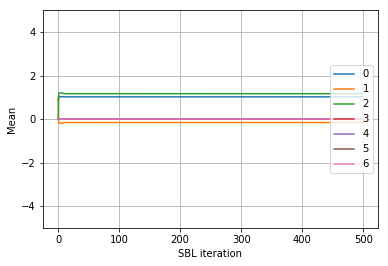

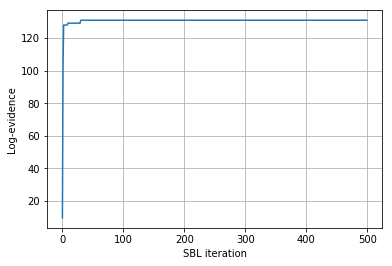

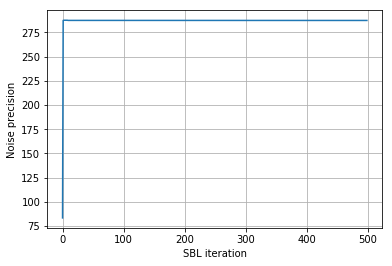

In [6]:
plt.figure(1)
for i in range(0,N): plt.plot(iterMean[i,:],label=str(i))
plt.grid(True)
plt.ylabel('Mean')
plt.xlabel('SBL iteration'); 
plt.ylim(Wlim)
plt.legend(loc='right', numpoints = 1);
plt.savefig('SBL_MEAN.eps',bbox_inches='tight')

plt.figure(2)
plt.plot(iterLogEvid)
plt.grid(True)
plt.ylabel('Log-evidence')
plt.xlabel('SBL iteration'); 
plt.savefig('SBL_LOGEVID.eps',bbox_inches='tight')

plt.figure(3)
plt.plot(iterRho)
plt.grid(True)
plt.ylabel('Noise precision')
plt.xlabel('SBL iteration'); 
plt.savefig('SBL_RHO.eps',bbox_inches='tight')
